In [ ]:
!pip install chronos-forecasting fev boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: This is taking longer than usual. You might need to provide the dependency resolve

In [ ]:
from chronos import BaseChronosPipeline
import torch
import numpy as np
from matplotlib import pyplot as plt
from typing import Sequence, Mapping, Optional
import types
from chronos.chronos2.dataset import Chronos2Dataset, DatasetMode, TensorOrArray
from tqdm import tqdm
import datasets
import pandas as pd
from functools import partial
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL
import fev

/tmp/ipython-input-3773754857.py:7: FutureWarning: Loading s3://autogluon/chronos-2 from CloudFront is deprecated and will be removed in a future version. Please specify a HuggingFace model_id instead. For example: Chronos2Pipeline.from_pretrained("amazon/chronos-2")
  pipeline = BaseChronosPipeline.from_pretrained("s3://autogluon/chronos-2", device_map="cuda", torch_dtype=torch.float32)
`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


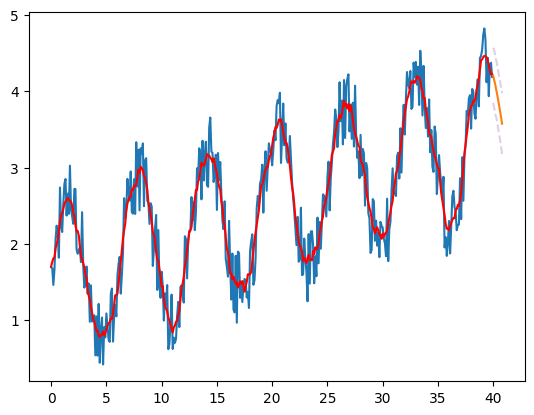

In [ ]:
pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda", torch_dtype=torch.float32)

def test_prediction(pipeline):
  timestep=0.1
  t = np.arange(400)*timestep
  sin_input = np.sin(t) + 0.05*t + 1

  sin_input += np.random.random(size=len(t))

  n = 9
  inputs = np.reshape(sin_input, (1, 1, -1))

  t_pred = t.max() + timestep + np.arange(n)*timestep
  pred_quants, pred_means = pipeline.predict_quantiles(inputs, prediction_length=n, quantile_levels=[0.1, 0.5, 0.9])

  K=9
  ma = np.pad(sin_input, (K//2, K-1-K//2), mode='edge')
  moving_avg = np.convolve(ma, np.ones(K)/K, mode='valid')

  fig, ax = plt.subplots()
  ax.plot(t, sin_input)
  ax.plot(t, moving_avg, color="red")
  ax.plot(t_pred, pred_means[0][0])

  ax.plot(t_pred, pred_quants[0][0,:,0], label='0.1 quantile', color='purple', linestyle='--', alpha=0.2)
  ax.plot(t_pred, pred_quants[0][0,:,2], label='0.9 quantile', color='purple', linestyle='--', alpha=0.2)

test_prediction(pipeline)

In [ ]:
def predict_quantiles(  # type: ignore[override]
    self,
    inputs: TensorOrArray
    | Sequence[TensorOrArray]
    | Sequence[Mapping[str, TensorOrArray | Mapping[str, TensorOrArray]]],
    prediction_length: int | None = None,
    quantile_levels: list[float] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    injector=None,
    interpreter=None,
    **predict_kwargs):

  print("Starting predict")
  mus = []
  sigmas = []
  if injector is not None:
    for map in inputs:
      mus.append(np.nanmean(map["target"][0]))
      sigmas.append(np.nanstd(map["target"][0]))
      injector(map)
  print("Injected covariates...")

  pred = self.original_predict_quantiles(inputs, prediction_length, quantile_levels, **predict_kwargs)

  print("Prediction made... Now interpreting")

  if interpreter is not None:
    return interpreter(pred, mus=mus, sigmas=sigmas)
  else:
    return pred

def augment1(map):
  targ = map["target"][0]
  targ = (targ - np.nanmean(targ))/np.nanstd(targ)
  exp = np.exp(targ);
  cube = np.pow(targ, 3)
  return {
    "cube": cube,
    "exp": exp,
    "inv": -targ,
    "ncube": -cube,
    "nexp": -exp
  }

def augment2(map):
  K = 9
  targ = map["target"][0]
  ma = np.pad(targ, (K//2, K-1-K//2), mode='edge')
  ma = np.convolve(ma, np.ones(K)/K, mode='valid')
  return {
    "ma": ma,
    "res": targ - ma
  }

def interpret1(pred, mus, sigmas):
  def inv(tensor):
    return torch.stack([
        tensor[0],
        torch.sign(tensor[1]) * torch.pow(torch.abs(tensor[1]), 1/3),
        torch.log(torch.clamp(tensor[2], min=0.01)),
        -tensor[3],
        torch.sign(-tensor[4]) * torch.pow(torch.abs(-tensor[4]), 1/3),
        torch.log(torch.clamp(-tensor[5], min=0.01)),
    ])

  list_quantiles = [inv(t) for t in pred[0]]
  list_preds = [inv(t) for t in pred[1]]
  list_quantiles = [torch.vstack([p[:3], p[3:].flip(2)]) for p in list_quantiles]
  list_quantiles = [torch.vstack([
      p[0].unsqueeze(0),
      p[1:]*sigma + mu]) for p, mu, sigma in zip(list_quantiles, mus, sigmas)]
  list_preds = [torch.vstack([
      p[0].unsqueeze(0),
      p[1:]*sigma + mu]) for p, mu, sigma in zip(list_preds, mus, sigmas)]
  list_quantiles = [torch.mean(p, 0).unsqueeze(0) for p in list_quantiles]
  list_preds = [torch.mean(p, 0).unsqueeze(0) for p in list_preds]
  return list_quantiles, list_preds

def interpret2(pred, **kwargs):
  list_quantiles = pred[0]
  list_preds = pred[1]
  list_quantiles = [0.5 * (p[0] + torch.sum(p[1:], 0)).unsqueeze(0) for p in list_quantiles]
  list_preds = [0.5 * (p[0] + torch.sum(p[1:], 0)).unsqueeze(0) for p in list_preds]
  return list_quantiles, list_preds

# def interpret2(pred):
#   list_quantiles = pred[0]
#   list_preds = pred[1]
#   list_quantiles = [torch.mean(p, 0).unsqueeze(0) for p in list_quantiles]
#   list_preds = [torch.mean(p, 0).unsqueeze(0) for p in list_preds]
#   return list_quantiles, list_preds

def cov_injector1(map):
  map["past_covariates"] = augment1(map)

def cov_injector2(map):
  map["past_covariates"] = augment2(map)

def mul_injector1(map):
  map["target"] = np.vstack([map["target"], *augment1(map).values()])

def mul_injector2(map):
  map["target"] = np.vstack([map["target"], *augment2(map).values()])




In [ ]:


def predict_with_model(
    task: fev.Task,
    batch_size: int = 100,
    device_map: str = "cuda",
    torch_dtype: torch.dtype = torch.float32,
    as_univariate: bool = False,
    seed: int = 123,
    model_name=None,
    injector=None,
    interpreter=None
) -> tuple[list[datasets.DatasetDict], float, dict]:
    pipeline = BaseChronosPipeline.from_pretrained(model_name, device_map=device_map, torch_dtype=torch_dtype)

    if injector is not None or interpreter is not None:
      pipeline.original_predict_quantiles = pipeline.predict_quantiles
      pipeline.predict_quantiles = types.MethodType(
        partial(predict_quantiles, injector=injector, interpreter=interpreter), pipeline)

    torch.manual_seed(seed)

    predictions_per_window, inference_time = pipeline.predict_fev(
        task, batch_size=batch_size, as_univariate=as_univariate,
    )

    extra_info = {
        "framework_version": chronos.__version__,
        "model_config": {
            "model_name": model_name,
            "batch_size": batch_size,
            "device_map": device_map,
            "torch_dtype": str(torch_dtype),
            "as_univariate": as_univariate,
            "seed": seed,
        },
    }
    return predictions_per_window, inference_time, extra_info



In [ ]:
model_name = "amazon/chronos-2"
num_tasks = None  # replace with `num_tasks = None` to run on all tasks
benchmark = fev.Benchmark.from_yaml(
    "tasks.yaml"
)

configs = {
    "n": (None, None),
    "c1": (cov_injector1, None),
    "c2": (cov_injector2, None),
    "m1": (mul_injector1, interpret1),
    "m2": (mul_injector2, interpret2),
}


for config_name, (injector, interpreter) in configs.items():
  summaries = []
  for task in benchmark.tasks[:num_tasks]:

      predictions, inference_time, extra_info = predict_with_model(
          task, model_name=model_name, as_univariate=True,
          injector=injector, interpreter=interpreter)
      evaluation_summary = task.evaluation_summary(
          predictions,
          model_name=model_name,
          inference_time_s=inference_time,
          extra_info=extra_info,
      )
      print(evaluation_summary)
      summaries.append(evaluation_summary)

  # Show and save the results
  summary_df = pd.DataFrame(summaries)
  summary_df.to_csv("results/" + model_name.replace("/", "-") + "-" + config_name + ".csv", index=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

monash_traffic/train-00000-of-00001.parq(…):   0%|          | 0.00/52.7M [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_traffic', 'horizon': 24, 'num_windows': 1, 'initial_cutoff': -24, 'window_step_size': 24, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 24, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_traffic', 'test_error': 0.8183648401254122, 'training_time_s': None, 'inference_time_s': 36.90465435400006, 'num_forecasts': 862, 'dataset_fingerprint': 'a395745939b7b0f3', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.8183648401254122, 'WQL': 0.2415144601579454, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_ma

monash_australian_electricity/train-0000(…):   0%|          | 0.00/16.9M [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_australian_electricity', 'horizon': 48, 'num_windows': 1, 'initial_cutoff': -48, 'window_step_size': 48, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 48, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_australian_electricity', 'test_error': 0.6291608941858241, 'training_time_s': None, 'inference_time_s': 0.28473101999998107, 'num_forecasts': 5, 'dataset_fingerprint': 'c3fa76db06a6f37a', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.6291608941858241, 'WQL': 0.0307282916777762, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2',

ercot/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'ercot', 'horizon': 24, 'num_windows': 1, 'initial_cutoff': -24, 'window_step_size': 24, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 24, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'ercot', 'test_error': 0.8317666162099394, 'training_time_s': None, 'inference_time_s': 0.4104790359999697, 'num_forecasts': 8, 'dataset_fingerprint': '95b91121d95f89c8', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.8317666162099394, 'WQL': 0.02595818995961132, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_map': 'cuda', 'torch

README.md: 0.00B [00:00, ?B/s]

chronos_datasets_extra.py: 0.00B [00:00, ?B/s]

The repository for autogluon/chronos_datasets_extra contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/autogluon/chronos_datasets_extra.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets_extra', 'dataset_config': 'ETTm', 'horizon': 24, 'num_windows': 1, 'initial_cutoff': -96, 'window_step_size': 24, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 96, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': '__ALL__', 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'ETTm', 'test_error': 0.5800350348712058, 'traini

exchange_rate/train-00000-of-00001.parqu(…):   0%|          | 0.00/402k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'exchange_rate', 'horizon': 30, 'num_windows': 1, 'initial_cutoff': -30, 'window_step_size': 30, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 5, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'exchange_rate', 'test_error': 1.8520462808037637, 'training_time_s': None, 'inference_time_s': 0.3543870460000562, 'num_forecasts': 8, 'dataset_fingerprint': 'a8476b6fa723f5ed', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.8520462808037637, 'WQL': 0.01211554348096732, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_map':

nn5/train-00000-of-00001.parquet:   0%|          | 0.00/203k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'nn5', 'horizon': 56, 'num_windows': 1, 'initial_cutoff': -56, 'window_step_size': 56, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'nn5', 'test_error': 0.5768131997356708, 'training_time_s': None, 'inference_time_s': 0.48417434000009507, 'num_forecasts': 111, 'dataset_fingerprint': '91434e4cabb44eab', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.5768131997356708, 'WQL': 0.14875220096534975, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_map': 'cuda', 'torch_d

monash_nn5_weekly/train-00000-of-00001.p(…):   0%|          | 0.00/64.6k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_nn5_weekly', 'horizon': 8, 'num_windows': 1, 'initial_cutoff': -8, 'window_step_size': 8, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_nn5_weekly', 'test_error': 0.8824978032511672, 'training_time_s': None, 'inference_time_s': 0.1580224269999917, 'num_forecasts': 111, 'dataset_fingerprint': '480088d6b89d7100', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.8824978032511672, 'WQL': 0.08159848760334655, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'devic

monash_weather/train-00000-of-00001.parq(…):   0%|          | 0.00/133M [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_weather', 'horizon': 30, 'num_windows': 1, 'initial_cutoff': -30, 'window_step_size': 30, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_weather', 'test_error': 0.7741443091778358, 'training_time_s': None, 'inference_time_s': 127.83754863800004, 'num_forecasts': 3010, 'dataset_fingerprint': '980478e7349a0e49', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.7741443091778358, 'WQL': 0.12532563330727492, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_

monash_covid_deaths/train-00000-of-00001(…):   0%|          | 0.00/59.0k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_covid_deaths', 'horizon': 30, 'num_windows': 1, 'initial_cutoff': -30, 'window_step_size': 30, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_covid_deaths', 'test_error': 35.40555568899733, 'training_time_s': None, 'inference_time_s': 0.4253370860000132, 'num_forecasts': 266, 'dataset_fingerprint': '6cdf94c2ac2fae09', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 35.40555568899733, 'WQL': 0.03921345797971282, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, '

monash_fred_md/train-00000-of-00001.parq(…):   0%|          | 0.00/412k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_fred_md', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_fred_md', 'test_error': 0.4687342588092461, 'training_time_s': None, 'inference_time_s': 0.509741694000013, 'num_forecasts': 107, 'dataset_fingerprint': 'a508fc699f3f3683', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.4687342588092461, 'WQL': 0.01953867848995001, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_m

m4_quarterly/train-00000-of-00001.parque(…):   0%|          | 0.00/13.3M [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'm4_quarterly', 'horizon': 8, 'num_windows': 1, 'initial_cutoff': -8, 'window_step_size': 8, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 4, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'm4_quarterly', 'test_error': 1.2007946313119195, 'training_time_s': None, 'inference_time_s': 32.95609515399997, 'num_forecasts': 24000, 'dataset_fingerprint': '97b166b18d38e710', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.2007946313119195, 'WQL': 0.07597317038198778, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_map': '

m4_yearly/train-00000-of-00001.parquet:   0%|          | 0.00/5.49M [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'm4_yearly', 'horizon': 6, 'num_windows': 1, 'initial_cutoff': -6, 'window_step_size': 6, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'm4_yearly', 'test_error': 3.3776163300521507, 'training_time_s': None, 'inference_time_s': 19.43213942700004, 'num_forecasts': 23000, 'dataset_fingerprint': '020f5777849c9c62', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 3.3776163300521507, 'WQL': 0.11725137563065079, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_map': 'cuda',

m5/train-00000-of-00001.parquet:   0%|          | 0.00/78.1M [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'm5', 'horizon': 28, 'num_windows': 1, 'initial_cutoff': -28, 'window_step_size': 28, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'm5', 'test_error': 0.9051109466324726, 'training_time_s': None, 'inference_time_s': 284.594837211, 'num_forecasts': 30490, 'dataset_fingerprint': '78a5b1db66dfb76c', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.9051109466324726, 'WQL': 0.5526742350208275, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_map': 'cuda', 'torch_dtype': 

monash_tourism_monthly/train-00000-of-00(…):   0%|          | 0.00/335k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_tourism_monthly', 'horizon': 24, 'num_windows': 1, 'initial_cutoff': -24, 'window_step_size': 24, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_tourism_monthly', 'test_error': 1.4225788673431046, 'training_time_s': None, 'inference_time_s': 0.7557814630001758, 'num_forecasts': 366, 'dataset_fingerprint': '3ce75ace84bef572', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.4225788673431046, 'WQL': 0.07252005705344397, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size

monash_tourism_quarterly/train-00000-of-(…):   0%|          | 0.00/177k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_tourism_quarterly', 'horizon': 8, 'num_windows': 1, 'initial_cutoff': -8, 'window_step_size': 8, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 4, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_tourism_quarterly', 'test_error': 1.5664895821880787, 'training_time_s': None, 'inference_time_s': 0.4404562109998551, 'num_forecasts': 427, 'dataset_fingerprint': 'f34c4184775eda7e', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.5664895821880787, 'WQL': 0.06487474792874588, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size

monash_tourism_yearly/train-00000-of-000(…):   0%|          | 0.00/81.5k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_tourism_yearly', 'horizon': 4, 'num_windows': 1, 'initial_cutoff': -4, 'window_step_size': 4, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_tourism_yearly', 'test_error': 3.66620679001609, 'training_time_s': None, 'inference_time_s': 0.3685985370000253, 'num_forecasts': 518, 'dataset_fingerprint': '7c477aee96f482c4', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 3.66620679001609, 'WQL': 0.1515261334920121, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'de

monash_car_parts/train-00000-of-00001.pa(…):   0%|          | 0.00/70.3k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_car_parts', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_car_parts', 'test_error': 0.8335596840955092, 'training_time_s': None, 'inference_time_s': 1.4714186829999107, 'num_forecasts': 2674, 'dataset_fingerprint': '1ba8c4719a51b23c', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.8335596840955092, 'WQL': 0.9610726206162793, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'dev

monash_hospital/train-00000-of-00001.par(…):   0%|          | 0.00/117k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_hospital', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_hospital', 'test_error': 0.7725826939544438, 'training_time_s': None, 'inference_time_s': 0.5915789200000745, 'num_forecasts': 767, 'dataset_fingerprint': 'e364316542f2f5c7', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.7725826939544438, 'WQL': 0.053917411168802956, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'devi

monash_cif_2016/train-00000-of-00001.par(…):   0%|          | 0.00/70.9k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_cif_2016', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_cif_2016', 'test_error': 0.9333503594955593, 'training_time_s': None, 'inference_time_s': 0.1008941740001319, 'num_forecasts': 72, 'dataset_fingerprint': '89203c02fafca301', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.9333503594955593, 'WQL': 0.010882637827750312, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'devic

monash_m1_yearly/train-00000-of-00001.pa(…):   0%|          | 0.00/30.8k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m1_yearly', 'horizon': 6, 'num_windows': 1, 'initial_cutoff': -6, 'window_step_size': 6, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m1_yearly', 'test_error': 3.8295751071068715, 'training_time_s': None, 'inference_time_s': 0.15870404799989046, 'num_forecasts': 181, 'dataset_fingerprint': 'bd7efdf4c711a830', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 3.8295751071068715, 'WQL': 0.13818015833668884, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device

monash_m1_quarterly/train-00000-of-00001(…):   0%|          | 0.00/48.4k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m1_quarterly', 'horizon': 8, 'num_windows': 1, 'initial_cutoff': -8, 'window_step_size': 8, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 4, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m1_quarterly', 'test_error': 1.6612861420685645, 'training_time_s': None, 'inference_time_s': 0.2614043869998568, 'num_forecasts': 203, 'dataset_fingerprint': '5dd7170c16393209', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.6612861420685645, 'WQL': 0.08337263393841252, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'd

monash_m1_monthly/train-00000-of-00001.p(…):   0%|          | 0.00/244k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m1_monthly', 'horizon': 18, 'num_windows': 1, 'initial_cutoff': -18, 'window_step_size': 18, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m1_monthly', 'test_error': 1.0270374213830005, 'training_time_s': None, 'inference_time_s': 0.7293635219998578, 'num_forecasts': 617, 'dataset_fingerprint': '88d42195e0f8e7cc', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.0270374213830005, 'WQL': 0.146557270462167, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'dev

monash_m3_monthly/train-00000-of-00001.p(…):   0%|          | 0.00/590k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m3_monthly', 'horizon': 18, 'num_windows': 1, 'initial_cutoff': -18, 'window_step_size': 18, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m3_monthly', 'test_error': 0.8134785411920558, 'training_time_s': None, 'inference_time_s': 1.4618071479999344, 'num_forecasts': 1428, 'dataset_fingerprint': '372532bc65a1f203', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.8134785411920558, 'WQL': 0.08873742940107783, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, '

monash_m3_yearly/train-00000-of-00001.pa(…):   0%|          | 0.00/100k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m3_yearly', 'horizon': 6, 'num_windows': 1, 'initial_cutoff': -6, 'window_step_size': 6, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m3_yearly', 'test_error': 2.9963263069447836, 'training_time_s': None, 'inference_time_s': 0.4371909989999949, 'num_forecasts': 645, 'dataset_fingerprint': 'd607d91b11bbe4a1', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 2.9963263069447836, 'WQL': 0.14675682016103334, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'device_

monash_m3_quarterly/train-00000-of-00001(…):   0%|          | 0.00/189k [00:00<?, ?B/s]

{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_m3_quarterly', 'horizon': 8, 'num_windows': 1, 'initial_cutoff': -8, 'window_step_size': 8, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 4, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_m3_quarterly', 'test_error': 1.1621099894369955, 'training_time_s': None, 'inference_time_s': 0.5090272429999914, 'num_forecasts': 756, 'dataset_fingerprint': '6401670c504aa82b', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.1621099894369955, 'WQL': 0.07046167003232377, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autogluon/chronos-2', 'batch_size': 100, 'd

/tmp/ipython-input-1580993266.py:44: RuntimeWarning: invalid value encountered in divide
  targ = (targ - np.nanmean(targ))/np.nanstd(targ)


Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_covid_deaths', 'horizon': 30, 'num_windows': 1, 'initial_cutoff': -30, 'window_step_size': 30, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_covid_deaths', 'test_error': 36.07969412289863, 'training_time_s': None, 'inference_time_s': 2.1105731420002485, 'num_forecasts': 266, 'dataset_fingerprint': '6cdf94c2ac2fae09', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 36.07969412289863, 'WQL': 0.032737686142240374, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autog

/tmp/ipython-input-1580993266.py:44: RuntimeWarning: invalid value encountered in divide
  targ = (targ - np.nanmean(targ))/np.nanstd(targ)


Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_car_parts', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_car_parts', 'test_error': 0.8474257710633015, 'training_time_s': None, 'inference_time_s': 8.738043504000416, 'num_forecasts': 2674, 'dataset_fingerprint': '1ba8c4719a51b23c', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 0.8474257710633015, 'WQL': 0.9711262781613688, 'framework_version': '2.2.2', 'model_config': {'m

/tmp/ipython-input-1580993266.py:44: RuntimeWarning: invalid value encountered in divide
  targ = (targ - np.nanmean(targ))/np.nanstd(targ)


Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_covid_deaths', 'horizon': 30, 'num_windows': 1, 'initial_cutoff': -30, 'window_step_size': 30, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 1, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_covid_deaths', 'test_error': 37.80342459437264, 'training_time_s': None, 'inference_time_s': 2.196610401999351, 'num_forecasts': 266, 'dataset_fingerprint': '6cdf94c2ac2fae09', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 37.80342459437264, 'WQL': 0.04020156732491682, 'framework_version': '2.2.2', 'model_config': {'model_name': 'autoglu

/tmp/ipython-input-1580993266.py:44: RuntimeWarning: invalid value encountered in divide
  targ = (targ - np.nanmean(targ))/np.nanstd(targ)


Injected covariates...
Prediction made... Now interpreting
{'model_name': 'autogluon/chronos-2', 'dataset_path': 'autogluon/chronos_datasets', 'dataset_config': 'monash_car_parts', 'horizon': 12, 'num_windows': 1, 'initial_cutoff': -12, 'window_step_size': 12, 'min_context_length': 1, 'max_context_length': None, 'seasonality': 12, 'eval_metric': 'MASE', 'extra_metrics': ['WQL'], 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'id_column': 'id', 'timestamp_column': 'timestamp', 'target': 'target', 'generate_univariate_targets_from': None, 'known_dynamic_columns': [], 'past_dynamic_columns': [], 'static_columns': [], 'task_name': 'monash_car_parts', 'test_error': 1.1369714020266832, 'training_time_s': None, 'inference_time_s': 9.155807933999313, 'num_forecasts': 2674, 'dataset_fingerprint': '1ba8c4719a51b23c', 'trained_on_this_dataset': False, 'fev_version': '0.7.0', 'MASE': 1.1369714020266832, 'WQL': 1.1785729095988877, 'framework_version': '2.2.2', 'model_config': {'m

In [ ]:
import fev
import pandas as pd

configs = ["n", "c2", "c1", "m1", "m2"]

dfs = [pd.read_csv(f"results/amazon-chronos-2-{c}.csv") for c in configs]
for c, df in zip(configs, dfs):
    df["model_name"] = "chronos2-" + c

dfs.append(pd.read_csv("results/seasonal_naive.csv"))
df = pd.concat(dfs)

tasks = set.intersection(*[set(df["task_name"].unique()) for df in dfs])
tasks.remove("monash_covid_deaths")
print(tasks)

df = df[df["task_name"].isin(tasks)]

In [ ]:
fev.leaderboard(df)

In [ ]:
df.groupby("model_name")[["MASE", "WQL", ""]].mean().sort_values()